# Texture-based separation to refine building meshes 

## Workflow
- Use Texture segmentation to separate the different materials in the meshes
- Detect the edges on the texture
- Convert the detected edges to hough lines
- project the uv coordinates of the mesh onto the plane
- Cut the triangles with the detected lines
- Define the new faces with the edge boundaries
- Segment the different connected zones using region growing


## Setup
Importing the Packages and defining the parameters

In [31]:
%load_ext autoreload
%autoreload 2

from context import segmentationtools as st
import cv2
import open3d as o3d
import math
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
#import the 3D mesh
meshPath = "../../../localfiles/TestWall.obj"
mesh = o3d.io.read_triangle_mesh(meshPath, True)

## Texture Segmentation

- We want to group textures and reduce their detail for better edge detection
- use Factorisation based Texture segmentation


Estimated segment number: 2
Texture is segmented


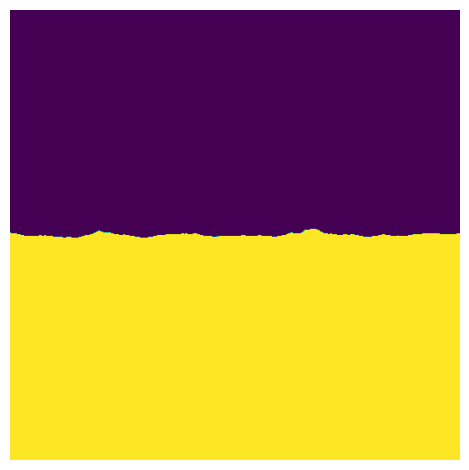

In [34]:
import segmentationtools.fseg as fseg

windowSize = 20
omegaVal = 0.2

texture = np.asarray(mesh.textures[0])
grayTexture = cv2.resize(cv2.cvtColor(texture, cv2.COLOR_BGR2GRAY), (512, 512))
# define filter bank and apply to image. for color images, convert rgb to grey scale and then apply filter bank
filter_list = [('log', .5, [3, 3]), ('log', 1, [5, 5]),
                ('gabor', 1.5, 0), ('gabor', 1.5, math.pi/2), ('gabor', 1.5, math.pi/4), ('gabor', 1.5, -math.pi/4),
                ('gabor', 2.5, 0), ('gabor', 2.5, math.pi/2), ('gabor', 2.5, math.pi/4), ('gabor', 2.5, -math.pi/4)
                ]
filter_out = fseg.image_filtering(grayTexture, filter_list=filter_list)
# include original image as one band
Ig = np.concatenate((np.float32(grayTexture.reshape((grayTexture.shape[0], grayTexture.shape[1], 1))), filter_out), axis=2)
# run segmentation. try different window size, with and without nonneg constraints
segmentedTexture = fseg.Fseg(Ig, ws=windowSize, segn=0, omega=omegaVal, nonneg_constraint=False)
# Remap to greyscale
a = segmentedTexture
segmentedMappedTexture = np.round(np.interp(a, (a.min(), a.max()), (0, 255))).astype(np.uint8)
print("Texture is segmented")
st.show_img(segmentedMappedTexture, bw=False)

## Edge Detection

- The patched image is pefect to detect the boundaries of the textures
- Use canny or HED edge detection
- Find the hough lines to get straight lines in the dtected edges

### Canny

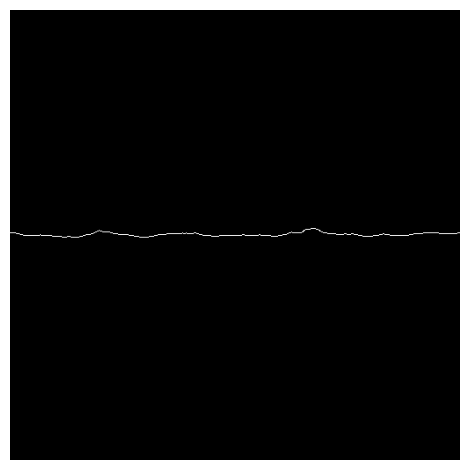

In [39]:
# perform Canny edge tedection to find sharp gradients
dst = cv2.Canny(segmentedMappedTexture, 100, 300, None, 3)
dstp = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

st.show_img(dstp)

### Houghlines P

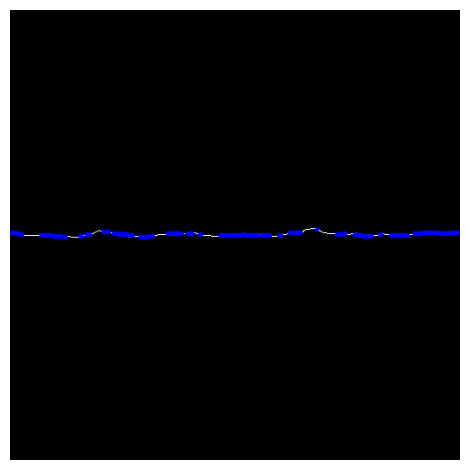

In [36]:
dstp2 = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
linesP = cv2.HoughLinesP(dst, 1, np.pi / 360, 30, None, 0, 0)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(dstp2, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

st.show_img(dstp2)

### Houghlines

[[[255.          1.5707964]]]


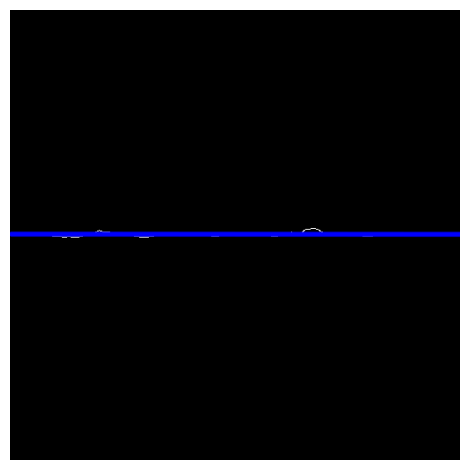

In [40]:
# Lets apply Standard HoughLine transform to detect lines
dstp2 = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
lines = cv2.HoughLines(dst, 2, np.pi / 120, 150, None, 0, 0)
print(lines)
# Below we will display the result by drawing lines
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
        cv2.line(dstp2, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)

st.show_img(dstp2)

## Face Slicing

- slice the triangles that are in the path of the new lines
- check for continuity in adjacent faces to continue the line

### UV Plane Mapping

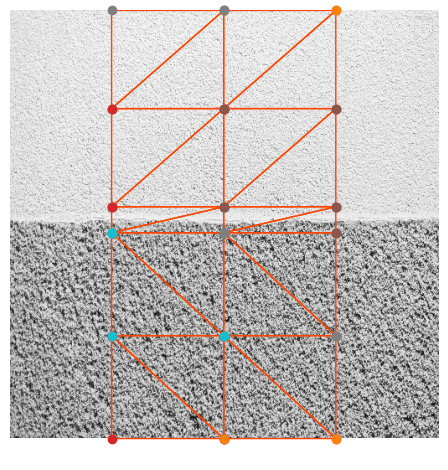

In [51]:
# Plot the triangles on the uv plane
# Scale the uv coordinates with the image dimensions
uvPoints = np.asarray(mesh.triangle_uvs) * np.array([segmentedMappedTexture.shape[1],segmentedMappedTexture.shape[0]])
plt.axis('off')
plt.tight_layout()
plt.imshow(grayTexture, cmap='gray')

for i in range((int)(len(uvPoints)/3)):
    plt.fill(*zip(*uvPoints[3*i:3*i+3]), facecolor='none', edgecolor='orangered', linewidth=1)
    plt.scatter(*zip(*uvPoints[3*i:3*i+3]), clip_on=False)
plt.show()

### Finding the intersectionPoints (Optional)

The resulting intersection points are: 
 [[301.88468707 255.0000132 ]
 [255.02310181 255.00001115]
 [167.85111918 255.00000734]
 [120.98969269 255.00000529]
 [389.05703735 255.00001701]
 [301.88468707 255.0000132 ]
 [255.02310181 255.00001115]
 [167.85111918 255.00000734]]


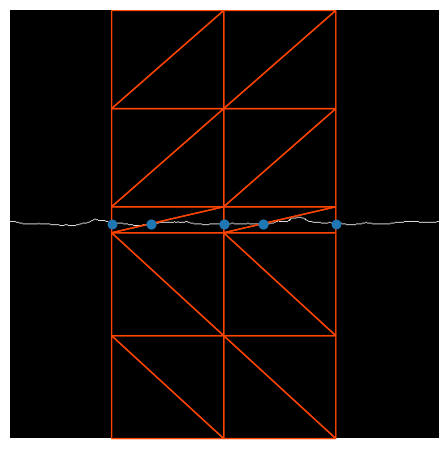

In [52]:
import segmentationtools as st
points = []

lineNr = 0

for i in range((int)(len(uvPoints)/3)):
    newPoints = st.find_triangle_intersection(uvPoints[3*i:3*i+3], st.get_edge_points(lines[lineNr], segmentedMappedTexture.shape[1], segmentedMappedTexture.shape[0]))
    if (newPoints is not None): 
        points.append(newPoints)

points = np.array(points).reshape((-1,2)) #reshape to a nx2 array
print("The resulting intersection points are: \n", points)

rho = lines[lineNr][0][0]
theta = lines[lineNr][0][1]
a = math.cos(theta)
b = math.sin(theta)
x0 = a * rho
y0 = b * rho
pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
cv2.line(segmentedMappedTexture, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)
plt.axis('off')
plt.tight_layout()
plt.imshow(dstp)
for i in range((int)(len(uvPoints)/3)):
    plt.fill(*zip(*uvPoints[3*i:3*i+3]), facecolor='none', edgecolor='orangered', linewidth=1)
plt.scatter(*zip(*points))
plt.show()


### Triangle Slicing

In [56]:
# Perform the triangle slicing algorithm for each triangle seperatly
uv_coords = np.asarray(mesh.triangle_uvs) * np.array([segmentedMappedTexture.shape[1],segmentedMappedTexture.shape[0]])
verts = np.asarray(mesh.vertices)
bounds = [segmentedMappedTexture.shape[1], segmentedMappedTexture.shape[0]]
edgePoints = st.get_edge_points(lines[lineNr],bounds[0], bounds[1])

new_vertices = []
new_uvs = []
new_triangles = []
nrOfVerts = 0
nrOfOfVerts = 0

for triangle in mesh.triangles:
    points_uv = np.array([uv_coords[nrOfOfVerts],uv_coords[nrOfOfVerts+1],uv_coords[nrOfOfVerts+2]])
    nrOfOfVerts+=3
    points_3d = np.array([verts[triangle[0]],verts[triangle[1]],verts[triangle[2]]])
    newTriangles,newTriangles_3d = st.cut_triangle(points_uv, edgePoints, points_3d)
    for i in range(len(newTriangles)):
        new_vertices.append(newTriangles_3d[i])
        new_uvs.append(newTriangles[i] / np.array([segmentedMappedTexture.shape[1],segmentedMappedTexture.shape[0]]))
        new_triangles.append([nrOfVerts, nrOfVerts+1, nrOfVerts+2])
        nrOfVerts += 3


### Creating the Updated Mesh

In [57]:
newMesh = st.create_mesh(new_vertices, new_triangles, new_uvs, texture)

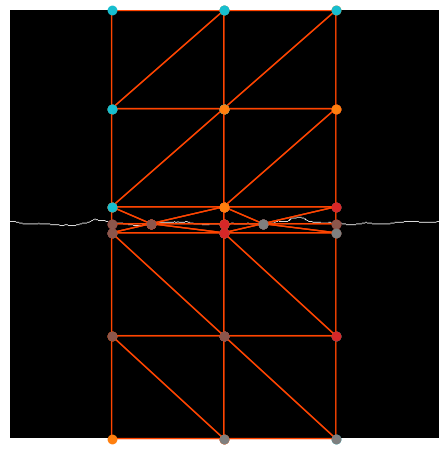

In [64]:
# Plot the triangles on the uv plane
# Scale the uv coordinates with the image dimensions
uvPoints = np.asarray(newMesh.triangle_uvs) * np.array([segmentedMappedTexture.shape[1],segmentedMappedTexture.shape[0]])
plt.axis('off')
plt.tight_layout()
plt.imshow(grayTexture, cmap='gray')
plt.imshow(dstp)

for i in range((int)(len(uvPoints)/3)):
        plt.fill(*zip(*uvPoints[3*i:3*i+3]), facecolor='none', edgecolor='orangered', linewidth=1)
        plt.scatter(*zip(*uvPoints[3*i:3*i+3]), clip_on=False)
plt.show()

### Show the Geometry

In [65]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.asarray(newMesh.vertices)[6:9])
o3d.visualization.draw_geometries([newMesh, pcd],mesh_show_wireframe=True)

## Object Segmentation

- use the texture blobs and adjacent faces region growing to segment the different objects

In [ ]:
import segmentationtools as st
newMesh.textures = [o3d.geometry.Image(cv2.cvtColor(segmentedMappedTexture, cv2.COLOR_GRAY2RGB))]


In [ ]:
# split the mesh based on the texture color and adjacency

# open3d adjacency list to get neighbouring verteces

### Face adjacency


In [144]:
# Prepare the mesh for separation
triangle_adjacent = []
triangleIndexes = np.full(len(newMesh.triangles),-1)
currentIndex = 0
nrOfTris = len(newMesh.triangles)

mesh_verts = np.asarray(newMesh.vertices)
mesh_tris = np.asarray(newMesh.triangles)
mesh_uvs = np.asarray(newMesh.triangle_uvs) * np.array([segmentedMappedTexture.shape[1],segmentedMappedTexture.shape[0]])
mesh_tris_positions = np.zeros(np.append(np.array(mesh_tris.shape),3))
mesh_tris_values = np.full(len(newMesh.triangles),0)
for i in range(len(mesh_tris)):
    for j in range(3):
        mesh_tris_positions[i][j] = mesh_verts[mesh_tris[i][j]]

    points_uv = np.array([mesh_uvs[3*i],mesh_uvs[3*i+1],mesh_uvs[3*i+2]])
    mesh_tris_values[i] = st.get_tri_pixel_value(points_uv, segmentedMappedTexture )
print(mesh_tris_positions.shape)

(28, 3, 3)


In [145]:
def mark_adjacent(i,adjacents):
    global triangleIndexes
    global mesh_tris_values
    global mesh_tris_positions
    global currentIndex
    #compare all adjacents
    for idx in adjacents:
        if(triangleIndexes[idx] != -1): # ignore the already seglented cases
                    continue
        if(mesh_tris_values[idx] == mesh_tris_values[i]):
                #print("Triangle:", idx, " \n value:", mesh_tris_values[idx])
                # both tris have the same pixel value
                triangleIndexes[idx] = currentIndex
                newAdjacents = st.find_adjacent_triangles(mesh_tris_positions[idx], mesh_tris_positions)
                mark_adjacent(idx, newAdjacents)

In [146]:
# check every face
for i in range(len(mesh_tris)):
    # Check if the triangle is not already segmented
    if(triangleIndexes[i] != -1):
        continue
    # give the new itteration a new index nr
    triangleIndexes[i] = currentIndex 
    # look for adjacent triangles with the same color as long as it can
    foundAll = False
    adjacents = st.find_adjacent_triangles(mesh_tris_positions[i], mesh_tris_positions)
    mark_adjacent(i,adjacents)
    print("Found all adjacent tris with index: ", currentIndex)   
    currentIndex +=1

print(triangleIndexes)

Found all adjacent tris with index:  0
Found all adjacent tris with index:  1
[0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1]


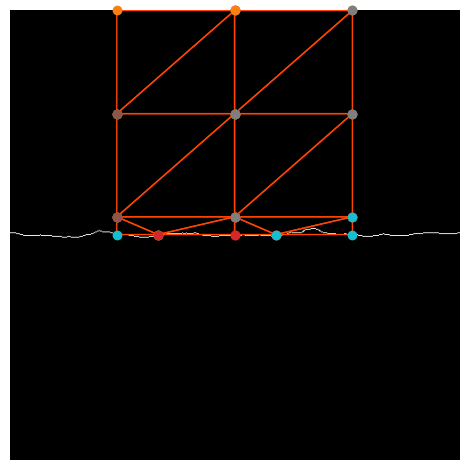

In [150]:
# Plot the triangles on the uv plane
# Scale the uv coordinates with the image dimensions
uvPoints = np.asarray(newMesh.triangle_uvs) * np.array([segmentedMappedTexture.shape[1],segmentedMappedTexture.shape[0]])
plt.axis('off')
plt.tight_layout()
plt.imshow(grayTexture, cmap='gray')
plt.imshow(dstp)

for i in range((int)(len(uvPoints)/3)):
    if(triangleIndexes[i] == 0):
        plt.fill(*zip(*uvPoints[3*i:3*i+3]), facecolor='none', edgecolor='orangered', linewidth=1)
        plt.scatter(*zip(*uvPoints[3*i:3*i+3]), clip_on=False)
plt.show()

In [148]:
import open3d
import numpy as np

mesh = open3d.geometry.TriangleMesh()
np_vertices = newMesh.vertices
np_triangles = []

for i in range(len(triangleIndexes)):
    if(triangleIndexes[i] == 0):
        np_triangles.append(np.asarray(newMesh.triangles)[i])


mesh.vertices = open3d.utility.Vector3dVector(np_vertices)
mesh.triangles = open3d.utility.Vector3iVector(np.array(np_triangles).reshape(-1,3))


In [149]:

open3d.visualization.draw_geometries([mesh])

In [ ]:
import copy
print("We make a partial mesh of only the first half triangles.")
mesh1 = copy.deepcopy(mesh)
mesh1.triangles = o3d.utility.Vector3iVector(
    np.asarray(mesh1.triangles)[])
mesh1.triangle_normals = o3d.utility.Vector3dVector(
    np.asarray(mesh1.triangle_normals)[:len(mesh1.triangle_normals) // 2, :])
print(mesh1.triangles)
o3d.visualization.draw_geometries([mesh1])